![cover](./images/uber-eats-decade-review-2948.jpeg)

# NLP-App-Sentiment-Analysis
Author: Jennifer Ha
***

## Overview
With their recent successful real estate investment in New York, our client Stellar Property Group seeks to expand their listings in California, which happens to be the other state with the most Fortune 500 company headquarters besides New York. Our client believes the trends and contributing factors that they saw in New York, especially the continued job growth will also positively impact the home values in California. The team is looking for recommendations on top 5 zipcodes to invest in California, and this analysis will also provide them with short-term vs. long-term investment decisions.

## Business Understanding
The goal of this analysis is to identify the top 5 zipcodes for our client to invest in California. The team is not quite familiar with the West Coast real estate market, and therefore, has asked to take risk factor into consideration. The results from this analysis will provide them with the forecast of next 10 year mean house values in the top 5 zipcodes as well as expected ROI in 1 year, 3 years, 5 years, and 10 years. 

## Data
The dataset for this analysis comes from [Zillow Research](https://www.zillow.com/research/data/), which contains the median home sales prices in 14,723 individual zipcodes from April 1996 through April 2018. Each row represents a unique zip code indexed with RegioinID, and contains location info and median housing sales prices for each month.

In [1]:
# Import all libraries & packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import glob
import string
from PIL import Image
import urllib.request

# Import standard packages for Natural Language Processing
import nltk
from nltk import FreqDist, word_tokenize, regexp_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud

# Importa SciKit Learn packages for modeling and model evaluation
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import classification_report, plot_roc_curve
from sklearn.metrics import plot_confusion_matrix, roc_curve

# Import LIME packages for feature interpretation
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer



In [2]:
# Set random seed
np.random.seed(27)

# Set no limit to column width to view full review text
pd.options.display.max_colwidth = None

## Importing Data

In [3]:
all_files = [
    'https://raw.githubusercontent.com/jennifernha/NLP-App-Reviews-Sentiment-Analysis/master/data/caviar-order-food-delivery.csv',
    'https://raw.githubusercontent.com/jennifernha/NLP-App-Reviews-Sentiment-Analysis/master/data/deliveroo-food-delivery.csv',
    'https://raw.githubusercontent.com/jennifernha/NLP-App-Reviews-Sentiment-Analysis/master/data/doordash-food-delivery.csv',
    'https://raw.githubusercontent.com/jennifernha/NLP-App-Reviews-Sentiment-Analysis/master/data/foodpanda-food-delivery.csv',
    'https://raw.githubusercontent.com/jennifernha/NLP-App-Reviews-Sentiment-Analysis/master/data/grubhub-local-food-delivery.csv',
    'https://raw.githubusercontent.com/jennifernha/NLP-App-Reviews-Sentiment-Analysis/master/data/postmates-fast-delivery.csv',
    'https://raw.githubusercontent.com/jennifernha/NLP-App-Reviews-Sentiment-Analysis/master/data/seamless-local-food-delivery.csv',
    'https://raw.githubusercontent.com/jennifernha/NLP-App-Reviews-Sentiment-Analysis/master/data/toast-takeout-delivery.csv',
    'https://raw.githubusercontent.com/jennifernha/NLP-App-Reviews-Sentiment-Analysis/master/data/uber-eats-food-delivery.csv',
    'https://raw.githubusercontent.com/jennifernha/NLP-App-Reviews-Sentiment-Analysis/master/data/zomato-food-delivery-dining.csv'
]
    

In [4]:
# Create a list of all loaded review text dataframes
df_list = []

for file in all_files:
    temp_df = pd.read_csv(file)
    df_list.append(temp_df)

In [5]:
# Concatenate all tables into a single dataframe
df = pd.concat(df_list, axis=0, ignore_index=True)
df

,date,userName,title,review,rating,isEdited,app_name,app_id,developerResponse
0,9/17/20 17:12,Good64774,Mixed feelings,"Caviar used to be a great app. Top quality restaurants, working app, good service. But they recently merged with DoorDash which I have found to be a notoriously worse app. Since the merger, the app seemed to change and your delivery drivers are now from “Dashers”. When you order now and have an issue and try to chat Caviar sometimes their servers are down or you can’t get a hold of them. Your left to call the restaurant who may tell you your food has been ready for a half hour but DoorDash/Caviar hasn’t picked it up and is unreachable right now. Typical DoorDash problems. Although the app needs work and the DoorDash merger is disappointing. When I finally have been able to reach the company and explain various issues. Caviar does issue refunds and credits. This is a positive that some apps like UberEats or Postmates rarely provide. Caviar’s credits/refunds are close to the high level of Seamless/Grubhub. Only reason Seamless/Grubhub are better in this area is refunds and credits can be issued automatically in the app with ease if you run into issues. Caviar, as mentioned above can be difficult to reach and requires more explanation. Ultimately if the Caviar app improves the accessibility of their customer service and they continue to provide credits, I would consider changing my review back to 5 stars. On the other hand, if I keep running into these app issues or if they stop providing credits and refunds for issues I would lower the rating. I’m on the fence.",5,False,caviar-order-food-delivery,931355786,NaN
1,5/20/20 18:18,weterpest,"Unreliable, Unhelpful","They have such a great selection of restaurants but service is SO unreliable! I have ordered maybe 5 times through them and the last three have all been really frustrating.\n\nThe last time I kept calling saying that the driver’s location on the map was not updating and the estimated delivery time kept getting pushed back. The customer service people would just read the estimated delivery time and disconnect the chat without ever reaching out to the driver. Two and a half hours after my food had been picked up and still not delivered, I finally figured out that the driver had car issues and the order was cancelled (3+ hours after being placed). This same type of situation has happened two times other times with the driver having car issues after picking up my order and getting here super late with food that has been sitting out in a car for at least an hour after being picked up, and customer service just doesn’t really do anything to figure it out or get a replacement order sent. I get that car issues happen, but three times in a row with this app isn’t a great track record considering that this has NEVER happened with competitor apps. \n\nI was really excited when I found Caviar because of the really great selection of restaurants, but I ended up deleting my account after this last time.",2,False,caviar-order-food-delivery,931355786,NaN
2,11/4/20 0:18,Mighty Power,Deliveries take too long,"Well for the last six months understanding pandemic aside because Uber and seamless are doing the same and they are not as late as they are and you are able to reach them, they apologize and always find the best solution or at least give you a credit to make it worthwhile. Caviar support team is easy on saying goodbyes, take a long time and then get back to you with no answer or problem fix, so for the last 10 or so orders all close by restaurants from my house, I waited about an hour to find out the driver was lost and was calling me in Spanish or the driver never showed up, and mostly I had to basically cancel the order and re-order again, I am finding out that the only way to get an order is to first order and then contact Support to make sure they are reaching out to somebody to get your food picked up, I can’t be using an app as such and always waiting around an 

## Data Preparation

In [6]:
# Get summary of the DataFrame 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67033 entries, 0 to 67032
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               67033 non-null  object
 1   userName           67033 non-null  object
 2   title              67033 non-null  object
 3   review             67033 non-null  object
 4   rating             67033 non-null  int64 
 5   isEdited           67033 non-null  bool  
 6   app_name           67033 non-null  object
 7   app_id             67033 non-null  int64 
 8   developerResponse  17242 non-null  object
dtypes: bool(1), int64(2), object(6)
memory usage: 4.2+ MB


In [7]:
# Check value counts for isEdited column
df['isEdited'].value_counts()

False    66093
True       940
Name: isEdited, dtype: int64

In [8]:
# Check value counts for developerResponse column
(df['developerResponse'].isna()).value_counts()

True     49791
False    17242
Name: developerResponse, dtype: int64

In [9]:
# Preview sample developer responses
df[df['developerResponse'].isna()==False]

,date,userName,title,review,rating,isEdited,app_name,app_id,developerResponse
3,12/24/18 2:52,anogawa,Horrendous customer service,"I would say the app experience is superior to other delivery apps, which is a shame because the customer service is terrible. \n\nOur expected delivery time upon ordering was 8:24 pm, which eventually got pushed back to 8:49 pm. The app notified us of the delay, which is better than other food delivery apps in which I’ve experienced delays but wasn’t notified. However, when order finally arrived, my husband noticed the delivery guy gave us the wrong order. Turns out he had given our order to the wrong person. Driver says he’ll contact support, saying they’ll probably re-deliver. I contact customer support on my own, and the rep offers a refund...okay, but at this point it’s past 9 pm and we still haven’t had dinner. I reply back saying it’s not okay. Rep blames it on me, saying that I selected that the items were missing and I preferred a refund. Except there are no options for “my driver messed up, get me a new order asap”. Eventually he offers $10. Their twitter account offers me $30, saying the restaurant is closed, which is why a re-delivery wasn’t available. \n\nThe correct response would have been to offer expedited delivery form another restaurant. At this point, I am not going to use this app again and will not recommend this app to my friends. Note to the developers: there are other food delivery apps out there, you are the new guy and you need to do more to stand out besides offer different restaurant selections.",1,False,caviar-order-food-delivery,931355786,"{'id': 6547062, 'body': ""Thanks for the feedback and I'm so sorry to hear about the issue you've experienced. We strive to provide the best experience with our support as possible, and clearly, we fell short here. Could you send us more details of your experience at trycaviar.com/contact with ATTN: Angie in the subject line? I'd be happy to help find a proper resolution."", 'modified': '2018-12-25T23:56:02Z'}"
5,6/4/19 0:34,LJS57,Bad Service for the Outrageous Delivery & Service Fees,"UPDATE: I contacted customer service as directed below. The short answer is, they aren’t willing to refund orders, it’s against their policy. Even if it shows up over an hour late (nearly 2 hours after the order was placed) and is cold and soggy- I’ve already gotten more than one credit for poor service. What I want is my money back. I informed them I’d be deleting the app, and got a canned response saying we hope this experience doesn’t reflect badly on them. I am deleting the app and will be ordering from DoorDash moving forward. DoorDash is now picking up many of the restaurants that were once specific to Caviar, they’re timely, and their fees are lower. I’m sorry Caviar, I tried. \n. . . . . . \nIf the food ever got to me in a timely manner, or even lukewarm, I wouldn’t be complaining. That said, nearly every time I’ve ever use this service, the delivery time increased from the posted 45-55 minutes, to 1.5-2 hours. That’s ridiculous. I wonder how they treat their restaurants as well because more than once I’ve received strange inaccurate orders- for example, a salad will show up bare (just a container of lettuce, minus any of the listed ingredients from the site), or most frequently, anything I add on as “extra” to a dish I get charged for, but the “extra” isn’t included. I’ve requested refunds, with no response. It’s a shame bc they work with some good places.",1,True,caviar-order-food-delivery,931355786,"{'id': 8970235, 'body': ""Thanks for the feedback and I'm so sorry to hear about the issue you've experienced. We strive to provide the best experience with our service and support as possible, and clearly we fell short here. Could you send us more details of your experience at trycaviar.com/contact with ATTN: Aicea in the subject line? I'd be happy to help find a proper resolution."", 'modified': '2019-06-04T00:34:55Z'}"
11,9/16/18 0:30,ndavidso

### Removing Duplicates

In [10]:
#Check for duplicates
df.title.duplicated().sum()

19571

In [11]:
# Check for duplicated rows
df[df.duplicated(keep=False)].sort_values('title')

,date,userName,title,review,rating,isEdited,app_name,app_id,developerResponse
1674,9/6/18 23:56,IFS123,Horrible horrible service in downtown Boston,You order something and it says it will\ntake an hour...then an 1.15....then 1.5....then 2.5 hours. \n\nThis is the third time this has happened to me. Never ordering from caviar again.,1,False,caviar-order-food-delivery,931355786,NaN
1675,9/6/18 23:56,IFS123,Horrible horrible service in downtown Boston,You order something and it says it will\ntake an hour...then an 1.15....then 1.5....then 2.5 hours. \n\nThis is the third time this has happened to me. Never ordering from caviar again.,1,False,caviar-order-food-delivery,931355786,NaN
21354,2017-12-18 22:38:24,Alaskagrown57,ORDERED MULTIPLE TIMES,I have ordered from different restaurants but always come back to this restaurant. The food is great and the delivery guy is always friendly. My food usually comes before the designated time and what I ordered has been right each time!!!! Maybe once it was a little late but that is because I live in moble home park and sometimes it is hard to find!!!!,5,False,grubhub-local-food-delivery,302920553,NaN
22086,2017-12-18 22:38:24,Alaskagrown57,ORDERED MULTIPLE TIMES,I have ordered from different restaurants but always come back to this restaurant. The food is great and the delivery guy is always friendly. My food usually comes before the designated time and what I ordered has been right each time!!!! Maybe once it was a little late but that is because I live in moble home park and sometimes it is hard to find!!!!,5,False,grubhub-local-food-delivery,302920553,NaN
21514,2017-12-10 21:23:44,Catzarn,Pretty Good!,"They work with a lot of restaurants and whenever I have an issue, the support staff always helps me resolve it.\n\nThere is a slight issue with the drivers having a small problem finding my apartment, they always go into my alley behind my building or to an address two blocks over, but that is more of their GPS/maps problem than theirs.",5,False,grubhub-local-food-delivery,302920553,NaN
22336,2017-12-10 21:23:44,Catzarn,Pretty Good!,"They work with a lot of restaurants and whenever I have an issue, the support staff always helps me resolve it.\n\nThere is a slight issue with the drivers having a small problem finding my apartment, they always go into my alley behind my building or to an address two blocks over, but that is more of their GPS/maps problem than theirs.",5,False,grubhub-local-food-delivery,302920553,NaN
21357,2017-12-15 02:56:55,Christian-In-Training,Questionable Drivers,"Placed an order THREE TIMES with them and the drivers decided not to come. Gave them instructions every single time about my apartment number. Instead of calling me about getting into my gated community with the passcode, they decided to just skip it. I called Grubhub and every time (almost 20 minute wait time each time) I told them to inform the driver to call me so I can let them in. Never happened. The customer service agents were not helpful. Even their supervisor Diana was just a jerk. 3 hours later I ended up having to go get it myself. Sometimes the “convenience” isn’t worth it.",1,False,grubhub-local-food-delivery,302920553,NaN
22174,2017-12-15 02:56:55,Christian-In-Training,Questionable Drivers,"Placed an order THREE TIMES with them and the drivers decided not to come. Gave them instructions every single time about my apartment number. Instead of calling me about getting into my gated community with the passcode, they decided to just skip it. I called Grubhub and every time (almost 20 minute wait time each time) I told them to inform the driver to call me so I can let them in. Never happened. The customer service agents were not helpful. Even their supervisor Diana was just a jerk. 3 hours later I ended up having to go get it myself. Sometimes the “convenience” isn’t worth it.",1,False,grubhub-local-food-delivery,302920553,NaN


In [12]:
#Remove duplicated rows
df = df.drop_duplicates()

In [13]:

# Check for multiple reviews for same app from same user
df[df.duplicated(['userName', 'app_name'], keep=False)]

,date,userName,title,review,rating,isEdited,app_name,app_id,developerResponse
38803,2018-09-11 23:16:10,Marcus350,I can’t use coupon,I got 10$ off on order made by app but I can use it because when I’m trying to checkout I’m getting message that order can’t be processed because for pick up I have to add phone number and @ address. And the best part of it that my phone and @ is in the system. When I removed coupon order went threw without any issue.,1,False,seamless-local-food-delivery,381840917,"{'id': 5675538, 'body': ""Oh No Marcus350! We're so sorry to hear that you're having the issues when using promotional codes. Please give us a call 800-256-1020 before check out and we're happy to help troubleshoot those promos with you! You can also check https://www.seamless.com/promoterms for full details."", 'modified': '2018-10-26T15:59:46Z'}"
40332,2018-09-11 23:43:11,Marcus350,Impossible to order by app,It is impossible to order by app it showing error message,1,False,seamless-local-food-delivery,381840917,"{'id': 5109101, 'body': 'Hi Marcus350! We are so sorry that you are experiencing issues with using the app. We would love the opportunity to resolve any issues that you may be experiencing. Please contact our Customer Care Team by giving us a call at (877) 256-1020. Thank you for choosing Seamless!', 'modified': '2018-09-19T01:31:36Z'}"
61065,2019-07-12 19:49:02,mohammedalhashimi,if you want your food late and cold ..... use this app,I have been using this app over a year and always my orders are late.,1,False,zomato-food-delivery-dining,434613896,"{'id': 9686084, 'body': 'Hi there, apologies for the inconvenience caused. Kindly drop us a mail (order@zomato.com) regarding this so that we can look in to what went wrong. Thanks.', 'modified': '2019-07-16T11:25:55Z'}"
61066,2019-07-12 19:49:02,mohammedalhashimi,if you want your food late and cold ..... use this app,I have been using this app over a year and always my orders are late.,1,False,zomato-food-delivery-dining,434613896,"{'id': 9686086, 'body': 'Hi there, apologies for the inconvenience caused. Kindly drop us a mail (order@zomato.com) regarding this so that we can look in to what went wrong. Thanks.', 'modified': '2019-07-16T11:25:58Z'}"


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67029 entries, 0 to 67032
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               67029 non-null  object
 1   userName           67029 non-null  object
 2   title              67029 non-null  object
 3   review             67029 non-null  object
 4   rating             67029 non-null  int64 
 5   isEdited           67029 non-null  bool  
 6   app_name           67029 non-null  object
 7   app_id             67029 non-null  int64 
 8   developerResponse  17242 non-null  object
dtypes: bool(1), int64(2), object(6)
memory usage: 4.7+ MB


While the review by Marcus 350 is legit, remove review by mohammedalhashimi 

In [15]:
# delete a single row by index value 0
df = df.drop(labels=61066, axis=0)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67028 entries, 0 to 67032
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               67028 non-null  object
 1   userName           67028 non-null  object
 2   title              67028 non-null  object
 3   review             67028 non-null  object
 4   rating             67028 non-null  int64 
 5   isEdited           67028 non-null  bool  
 6   app_name           67028 non-null  object
 7   app_id             67028 non-null  int64 
 8   developerResponse  17241 non-null  object
dtypes: bool(1), int64(2), object(6)
memory usage: 4.7+ MB


### Feature Engineering
we will combine them into one column, because both the title and review columns hold text that are relevant to our analysis. This will ensure that we are able to simultaneously examine information in the title and review columns.

In [16]:
# Combine title and review column to get full review text
df['combined_text'] = df['title'] + ". " + df['review']
df

,date,userName,title,review,rating,isEdited,app_name,app_id,developerResponse,combined_text
0,9/17/20 17:12,Good64774,Mixed feelings,"Caviar used to be a great app. Top quality restaurants, working app, good service. But they recently merged with DoorDash which I have found to be a notoriously worse app. Since the merger, the app seemed to change and your delivery drivers are now from “Dashers”. When you order now and have an issue and try to chat Caviar sometimes their servers are down or you can’t get a hold of them. Your left to call the restaurant who may tell you your food has been ready for a half hour but DoorDash/Caviar hasn’t picked it up and is unreachable right now. Typical DoorDash problems. Although the app needs work and the DoorDash merger is disappointing. When I finally have been able to reach the company and explain various issues. Caviar does issue refunds and credits. This is a positive that some apps like UberEats or Postmates rarely provide. Caviar’s credits/refunds are close to the high level of Seamless/Grubhub. Only reason Seamless/Grubhub are better in this area is refunds and credits can be issued automatically in the app with ease if you run into issues. Caviar, as mentioned above can be difficult to reach and requires more explanation. Ultimately if the Caviar app improves the accessibility of their customer service and they continue to provide credits, I would consider changing my review back to 5 stars. On the other hand, if I keep running into these app issues or if they stop providing credits and refunds for issues I would lower the rating. I’m on the fence.",5,False,caviar-order-food-delivery,931355786,NaN,"Mixed feelings. Caviar used to be a great app. Top quality restaurants, working app, good service. But they recently merged with DoorDash which I have found to be a notoriously worse app. Since the merger, the app seemed to change and your delivery drivers are now from “Dashers”. When you order now and have an issue and try to chat Caviar sometimes their servers are down or you can’t get a hold of them. Your left to call the restaurant who may tell you your food has been ready for a half hour but DoorDash/Caviar hasn’t picked it up and is unreachable right now. Typical DoorDash problems. Although the app needs work and the DoorDash merger is disappointing. When I finally have been able to reach the company and explain various issues. Caviar does issue refunds and credits. This is a positive that some apps like UberEats or Postmates rarely provide. Caviar’s credits/refunds are close to the high level of Seamless/Grubhub. Only reason Seamless/Grubhub are better in this area is refunds and credits can be issued automatically in the app with ease if you run into issues. Caviar, as mentioned above can be difficult to reach and requires more explanation. Ultimately if the Caviar app improves the accessibility of their customer service and they continue to provide credits, I would consider changing my review back to 5 stars. On the other hand, if I keep running into these app issues or if they stop providing credits and refunds for issues I would lower the rating. I’m on the fence."
1,5/20/20 18:18,weterpest,"Unreliable, Unhelpful","They have such a great selection of restaurants but service is SO unreliable! I have ordered maybe 5 times through them and the last three have all been really frustrating.\n\nThe last time I kept calling saying that the driver’s location on the map was not updating and the estimated delivery time kept getting pushed back. The customer service people would just read the estimated delivery time and disconnect the chat without ever reaching out to the driver. Two and a half hours after my food had been picked up and still not delivered, I finally figured out that the driver had car issues and the order was cancelled (3+ hours after being placed). This same type of situation has happened two times other times with the driver having car issues after picking up my order and

In [17]:
# Create a variable "corpus" containing all text
corpus = df['combined_text'].to_list()


In [18]:
corpus[3]

'Horrendous customer service. I would say the app experience is superior to other delivery apps, which is a shame because the customer service is terrible. \n\nOur expected delivery time upon ordering was 8:24 pm, which eventually got pushed back to 8:49 pm. The app notified us of the delay, which is better than other food delivery apps in which I’ve experienced delays but wasn’t notified. However, when order finally arrived, my husband noticed the delivery guy gave us the wrong order. Turns out he had given our order to the wrong person. Driver says he’ll contact support, saying they’ll probably re-deliver. I contact customer support on my own, and the rep offers a refund...okay, but at this point it’s past 9 pm and we still haven’t had dinner. I reply back saying it’s not okay. Rep blames it on me, saying that I selected that the items were missing and I preferred a refund. Except there are no options for “my driver messed up, get me a new order asap”. Eventually he offers $10. Their

In [19]:
# Replace all new-line characters with space
df['combined_text'] = df['combined_text'].replace(r'\n',' ', regex=True) 
# Create a variable "corpus" containing all text and verify
corpus = df['combined_text'].to_list()
corpus[3]

'Horrendous customer service. I would say the app experience is superior to other delivery apps, which is a shame because the customer service is terrible.   Our expected delivery time upon ordering was 8:24 pm, which eventually got pushed back to 8:49 pm. The app notified us of the delay, which is better than other food delivery apps in which I’ve experienced delays but wasn’t notified. However, when order finally arrived, my husband noticed the delivery guy gave us the wrong order. Turns out he had given our order to the wrong person. Driver says he’ll contact support, saying they’ll probably re-deliver. I contact customer support on my own, and the rep offers a refund...okay, but at this point it’s past 9 pm and we still haven’t had dinner. I reply back saying it’s not okay. Rep blames it on me, saying that I selected that the items were missing and I preferred a refund. Except there are no options for “my driver messed up, get me a new order asap”. Eventually he offers $10. Their t

## Exploratory Data Analysis (EDA)

### 1. Number of Reviews Distribution by App

In [20]:
# Check distribution of reviews for each app
df['app_name'].value_counts(normalize=True)

postmates-fast-delivery         0.149191
uber-eats-food-delivery         0.149191
doordash-food-delivery          0.149191
seamless-local-food-delivery    0.149191
grubhub-local-food-delivery     0.149147
zomato-food-delivery-dining     0.124754
caviar-order-food-delivery      0.060512
foodpanda-food-delivery         0.038894
deliveroo-food-delivery         0.018977
toast-takeout-delivery          0.010951
Name: app_name, dtype: float64

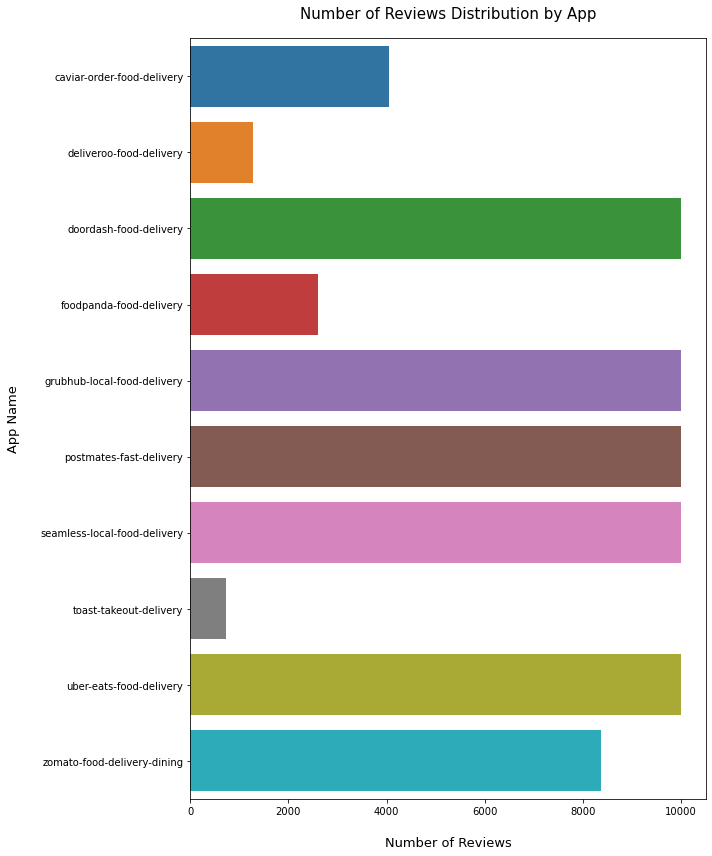

In [21]:
# Plot distribution of review count by app name
fig, ax = plt.subplots(figsize=(10,12))

sns.countplot(data=df, y='app_name', ax=ax)

plt.title('Number of Reviews Distribution by App', size = 15, pad = 20) 
plt.xlabel('Number of Reviews', size = 13, labelpad = 20)
plt.ylabel('App Name', size = 13, labelpad = 20)

plt.tight_layout()

### 2. Average Rating by App 


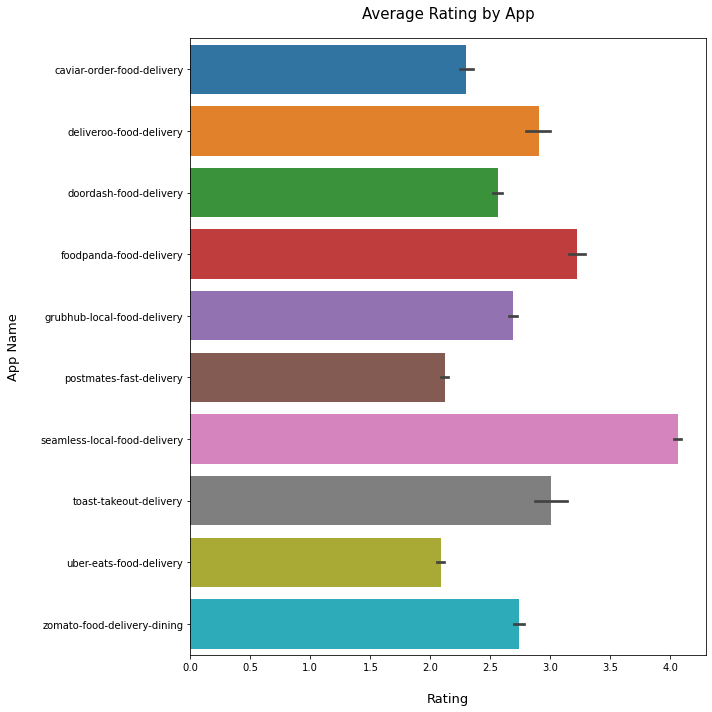

In [22]:
# Plot average rating by app 
fig, ax = plt.subplots(figsize=(10,10))

sns.barplot(data=df, x='rating', y='app_name')

plt.title('Average Rating by App', size = 15, pad = 20) 
plt.xlabel('Rating', size = 13, labelpad = 20)
plt.ylabel('App Name', size = 13, labelpad = 20)

plt.tight_layout()

### 3. Rating Distribution of All Apps 

In [23]:
# Check distribution of ratings across all apps
df['rating'].value_counts()

1    31175
5    21524
2     5202
4     5052
3     4075
Name: rating, dtype: int64

In [24]:
# Check distribution of ratings across all apps in percentages
df['rating'].value_counts(normalize=True)

1    0.465104
5    0.321120
2    0.077609
4    0.075371
3    0.060795
Name: rating, dtype: float64

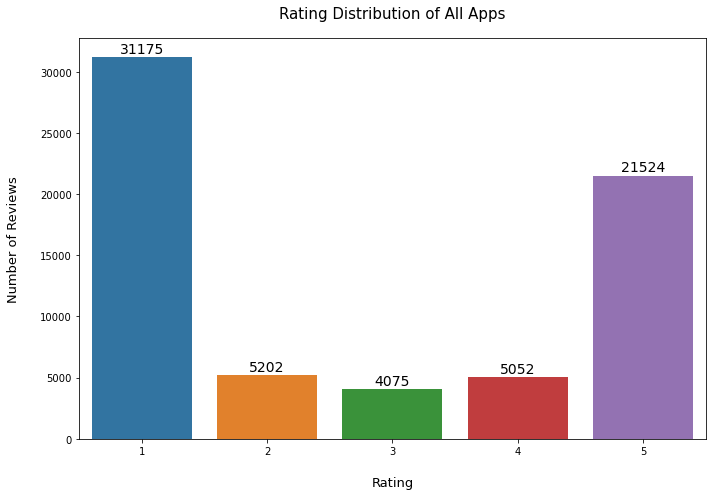

In [25]:
# Plot distribution of ratings across all apps
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x='rating', data=df, ax=ax)

plt.title('Rating Distribution of All Apps', size = 15, pad = 20) 
plt.xlabel('Rating', size = 13, labelpad = 20)
plt.ylabel('Number of Reviews', size = 13, labelpad = 20)

# Show number of reviews for each bar
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2.,
                                          p.get_height()),ha='center',
                va='center', fontsize=14, color='black', xytext=(0, 8),
                textcoords='offset points')

fig.tight_layout();

### 4. Rating Distribution of Apps with Most Reviews (Top 5)

In [26]:
# Create dataframe with data for top five apps in terms of review count
distribution_df = df[df['app_name'].isin(['doordash-food-delivery', 'grubhub-local-food-delivery',
                                          'postmates-fast-delivery', 'seamless-local-food-delivery',
                                          'uber-eats-food-delivery'])]

# Calculate average mean rating across top five apps
distribution_df = distribution_df.groupby('app_name')['rating']\
                                 .value_counts(normalize=True).to_frame()

# Rename percentage column and app_name column
distribution_df.columns = ['percentage']

# Reset index, rename app column and display result
distribution_df.reset_index(inplace=True)
distribution_df.columns = ['App', 'rating', 'percentage']
distribution_df

,App,rating,percentage
0,doordash-food-delivery,1,0.470600
1,doordash-food-delivery,5,0.263600
2,doordash-food-delivery,2,0.100900
3,doordash-food-delivery,3,0.089800
4,doordash-food-delivery,4,0.075100
5,grubhub-local-food-delivery,1,0.452736
6,grubhub-local-food-delivery,5,0.302291
7,grubhub-local-food-delivery,2,0.093028
8,grubhub-local-food-delivery,4,0.080224
9,grubhub-local-food-delivery,3,0.071722


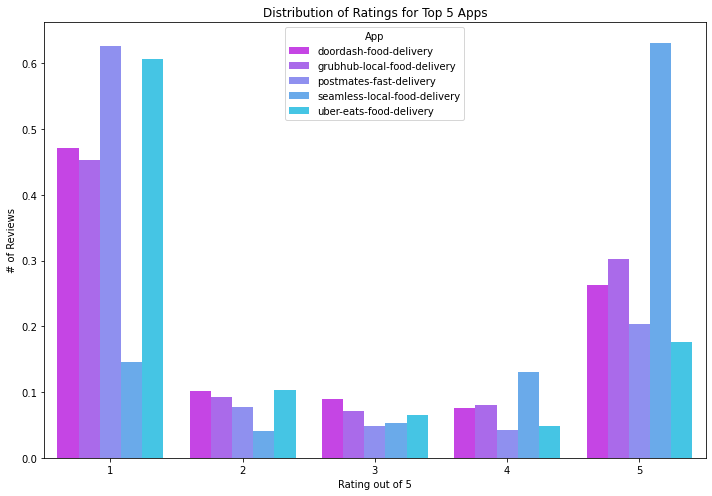

In [27]:
# Initialize figure
fig, ax = plt.subplots(figsize=(10,7))

# Create Barplot
sns.barplot(x='rating', y='percentage', hue='App', data=distribution_df, 
            ax=ax, palette='cool_r')

# Format barplot
ax.set_title('Distribution of Ratings for Top 5 Apps')
ax.set_ylabel('# of Reviews')
ax.set_xlabel('Rating out of 5')
fig.tight_layout();

write observation from the above

## Target Engineering

### Multi-class Sentiments

In [28]:
# Make new multiclass sentiment column based on rating
# 4 and above are positive, 3 is neutral, 1-2 are negative
conditions = [df['rating'] >= 4,
              df['rating'] == 3,
              df['rating'] <= 2,]
values = [2, 1, 0]

df['multi_sent'] = np.select(conditions, values)

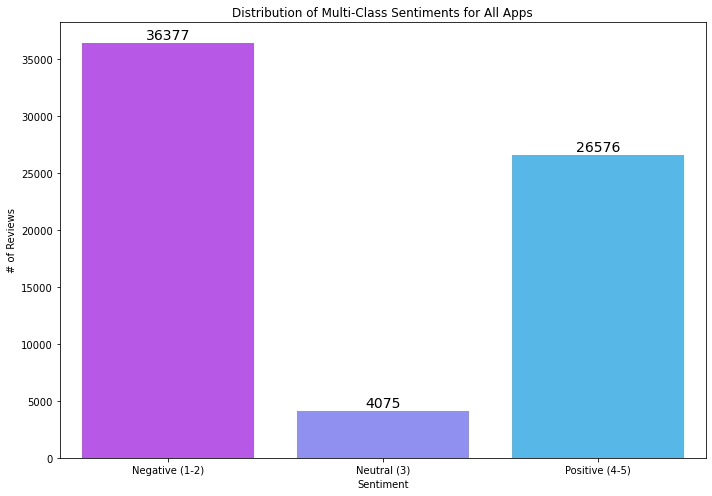

In [29]:
# Plot distribution of multiclass sentiments across all apps
fig, ax = plt.subplots(figsize=(10,7))

sns.countplot(x='multi_sent', data=df, ax=ax, palette='cool_r')

ax.set_title('Distribution of Multi-Class Sentiments for All Apps')
ax.set_ylabel('# of Reviews')
ax.set_xlabel('Sentiment')
ax.set_xticklabels(['Negative (1-2)','Neutral (3)', 'Positive (4-5)'])

for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2.,
                                          p.get_height()),ha='center',
                va='center', fontsize=14, color='black', xytext=(0, 8),
                textcoords='offset points')
fig.tight_layout();

### Binary Sentiments

In [30]:
# Make new binary sentiment column based on ratings
# 3 and above are positive, below 3 is negative
conditions = [df['rating'] >= 3,
              df['rating'] < 3]

values = [1,0]

df['sent_bin_3up'] = np.select(conditions, values)

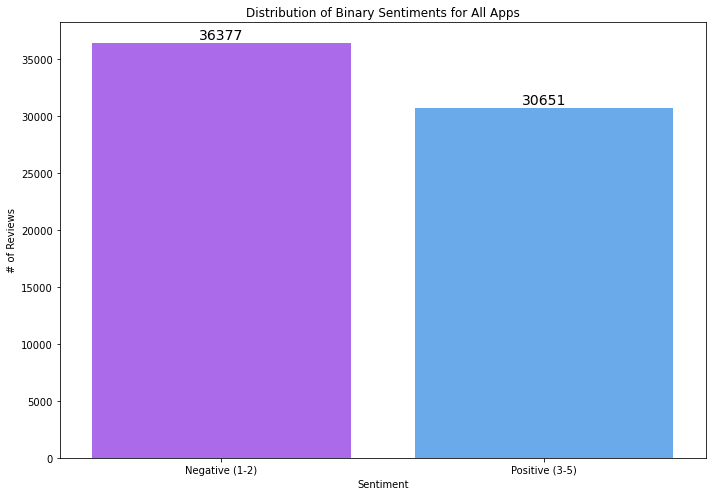

In [31]:
# Plot distribution of binary sentiments across all apps
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x='sent_bin_3up', data=df, ax=ax, palette='cool_r')
ax.set_title('Distribution of Binary Sentiments for All Apps')
ax.set_ylabel('# of Reviews')
ax.set_xlabel('Sentiment')
ax.set_xticklabels(['Negative (1-2)', 'Positive (3-5)'])

for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2.,
                                          p.get_height()),ha='center',
                va='center', fontsize=14, color='black', xytext=(0, 8),
                textcoords='offset points')
fig.tight_layout();

In [32]:
## Make new binary sentiment column based on ratings 4 and up
conditions = [
    df['rating'] >= 4,
    df['rating'] < 4,
]

values = [1,0]

df['sent_bin_4up'] = np.select(conditions, values)

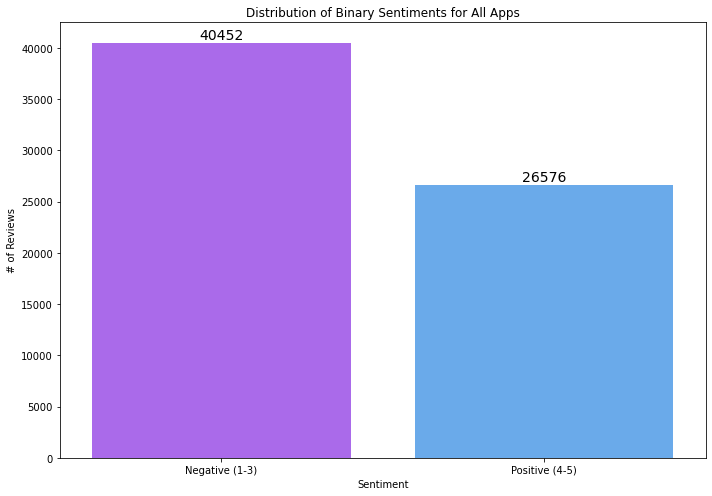

In [33]:
# Plot distribution of binary sentiments across all apps
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x='sent_bin_4up', data=df, ax=ax, palette='cool_r')
ax.set_title('Distribution of Binary Sentiments for All Apps')
ax.set_ylabel('# of Reviews')
ax.set_xlabel('Sentiment')
ax.set_xticklabels(['Negative (1-3)', 'Positive (4-5)'])

for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2.,
                                          p.get_height()),ha='center',
                va='center', fontsize=14, color='black', xytext=(0, 8),
                textcoords='offset points')
fig.tight_layout();

In [34]:
# Prepare final table with relevant columns
final_df = df[['date', 'userName', 'combined_text', 'rating', 'multi_sent', 
               'sent_bin_3up', 'sent_bin_4up']]
final_df

,date,userName,combined_text,rating,multi_sent,sent_bin_3up,sent_bin_4up
0,9/17/20 17:12,Good64774,"Mixed feelings. Caviar used to be a great app. Top quality restaurants, working app, good service. But they recently merged with DoorDash which I have found to be a notoriously worse app. Since the merger, the app seemed to change and your delivery drivers are now from “Dashers”. When you order now and have an issue and try to chat Caviar sometimes their servers are down or you can’t get a hold of them. Your left to call the restaurant who may tell you your food has been ready for a half hour but DoorDash/Caviar hasn’t picked it up and is unreachable right now. Typical DoorDash problems. Although the app needs work and the DoorDash merger is disappointing. When I finally have been able to reach the company and explain various issues. Caviar does issue refunds and credits. This is a positive that some apps like UberEats or Postmates rarely provide. Caviar’s credits/refunds are close to the high level of Seamless/Grubhub. Only reason Seamless/Grubhub are better in this area is refunds and credits can be issued automatically in the app with ease if you run into issues. Caviar, as mentioned above can be difficult to reach and requires more explanation. Ultimately if the Caviar app improves the accessibility of their customer service and they continue to provide credits, I would consider changing my review back to 5 stars. On the other hand, if I keep running into these app issues or if they stop providing credits and refunds for issues I would lower the rating. I’m on the fence.",5,2,1,1
1,5/20/20 18:18,weterpest,"Unreliable, Unhelpful. They have such a great selection of restaurants but service is SO unreliable! I have ordered maybe 5 times through them and the last three have all been really frustrating. The last time I kept calling saying that the driver’s location on the map was not updating and the estimated delivery time kept getting pushed back. The customer service people would just read the estimated delivery time and disconnect the chat without ever reaching out to the driver. Two and a half hours after my food had been picked up and still not delivered, I finally figured out that the driver had car issues and the order was cancelled (3+ hours after being placed). This same type of situation has happened two times other times with the driver having car issues after picking up my order and getting here super late with food that has been sitting out in a car for at least an hour after being picked up, and customer service just doesn’t really do anything to figure it out or get a replacement order sent. I get that car issues happen, but three times in a row with this app isn’t a great track record considering that this has NEVER happened with competitor apps. I was really excited when I found Caviar because of the really great selection of restaurants, but I ended up deleting my account after this last time.",2,0,0,0
2,11/4/20 0:18,Mighty Power,"Deliveries take too long. Well for the last six months understanding pandemic aside because Uber and seamless are doing the same and they are not as late as they are and you are able to reach them, they apologize and always find the best solution or at least give you a credit to make it worthwhile. Caviar support team is easy on saying goodbyes, take a long time and then get back to you with no answer or problem fix, so for the last 10 or so orders all close by restaurants from my house, I waited about an hour to find out the driver was lost and was calling me in Spanish or the driver never showed up, and mostly I had to basically cancel the order and re-order again, I am finding out that the only way to get an order is to first order and then contact Support to make sure they are reaching out to somebody to get your food picked up, I can’t be using an app as such and always waiting around an hour and sometimes get my food cold because it’s been out there so long or never get it and r

## Tokenization

In [35]:
# Create a single corpus out of all combined text
corpus = final_df['combined_text'].to_list()

# Convert Corpus to Tokens
tokens = regexp_tokenize(','.join(corpus), r"([a-zA-Z]+(?:’[a-z]+)?)")

# Preview tokens
tokens[:20]

['Mixed',
 'feelings',
 'Caviar',
 'used',
 'to',
 'be',
 'a',
 'great',
 'app',
 'Top',
 'quality',
 'restaurants',
 'working',
 'app',
 'good',
 'service',
 'But',
 'they',
 'recently',
 'merged']

In [36]:
# Check number of unique tokens
len(set(tokens))

41300

## Lemmatization

In [37]:
# Lemmatizing function for list of tokens
def lemmatize_tokens(tokens_list):
    """
    Lemmatizes list of string tokens and returns list of lemmatized
    string tokens.

    Args:
        tokens_list (list) : List of string tokens to be lemmatized.

    Returns:
        tokens_lemm (list) : List of lemmatized string tokens
    """
    
    lemmatizer = WordNetLemmatizer()
    tokens_lemm = [lemmatizer.lemmatize(word) for word in tokens_list]
    return tokens_lemm

In [38]:
# Lemmatize tokens
nltk.download('wordnet')
lemmatized_tokens = lemmatize_tokens(tokens)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jenniferha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [39]:
# Check number of unique tokens after lemmatization
len(set(lemmatized_tokens))

38515

## Stopword Removal

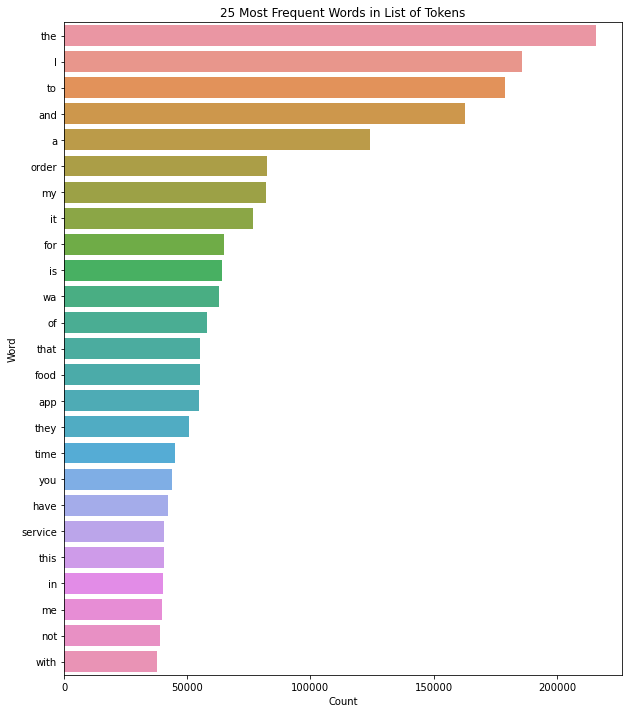

In [40]:
# Write function to create barplot of most common words
def most_freq(tokens, n=25, figsize=(12,7)):
    """
    Displays bar plot of n most frequent words in a list of tokens.

    Args:
        tokens (list) : List of string tokens to plot frequency for.
        n (int) : Number of tokens to plot.
        figsize (float, float) : Width, height in inches.

    Returns:
        
    """
    # Get frequency distribution of list of tokens
    freq = FreqDist(tokens)
    
    # Convert to DataFrame
    most_frequent_tokens = pd.DataFrame(freq.most_common(n),
                           columns=['word','count']).sort_values('count', 
                                                                 ascending=False)

    # Plot frequency distribution
    fig, ax = plt.subplots(figsize=(10,12))
    
    sns.barplot(data=most_frequent_tokens, y='word', x='count', 
                ax=ax, orient='h')

    ax.set_title(f'{n} Most Frequent Words in List of Tokens')
    ax.set_ylabel('Word')
    ax.set_xlabel('Count')
    
    
# Display frequency distirbution of lemmatized tokens
most_freq(lemmatized_tokens)

In [41]:
# Get all the stop words in the English language and preview first 25
nltk.download('stopwords')
stopwords_list = stopwords.words('english')
stopwords_list[:25]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jenniferha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers']

In [42]:
# Add punctuation to stopwords_list
stopwords_list.extend(string.punctuation)
stopwords_list[-10:]

['[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']

In [43]:
# Add additional punctuation below to stopwords_list
stopwords_list.extend(['“','”','...','’',"'",'``'])

In [44]:
# Remove stopwords from list of tokens
stopped_tokens = [w.lower() for w in lemmatized_tokens  if w.lower() \
                  not in stopwords_list]
stopped_tokens[:50]

['mixed',
 'feeling',
 'caviar',
 'used',
 'great',
 'app',
 'top',
 'quality',
 'restaurant',
 'working',
 'app',
 'good',
 'service',
 'recently',
 'merged',
 'doordash',
 'found',
 'notoriously',
 'worse',
 'app',
 'since',
 'merger',
 'app',
 'seemed',
 'change',
 'delivery',
 'driver',
 'dashers',
 'order',
 'issue',
 'try',
 'chat',
 'caviar',
 'sometimes',
 'server',
 'can’t',
 'get',
 'hold',
 'left',
 'call',
 'restaurant',
 'may',
 'tell',
 'food',
 'ha',
 'ready',
 'half',
 'hour',
 'doordash',
 'caviar']

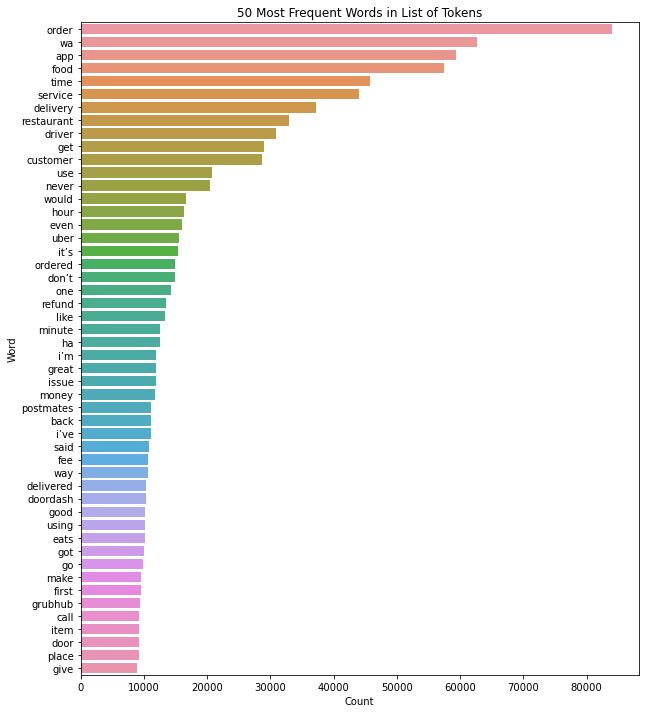

In [45]:
# Display frequency distirbution of lemmatized tokens after removing stopwords
most_freq(stopped_tokens, 50, figsize=(12,40))

remove words that provide no value + common app names
Now that we have removed common stopwords, we begin to see more insightful words. However, we can continue to remove some words that provide no value toward differentiating between negative, positive and neutral sentiments, including the word "app" and the common app names.

In [46]:
# Add common words unrelated to sentiment to stopwords_list
stopwords_list.extend(['wa','app', 'would', 'even', 'uber', 'it’s', 'don’t',
                       'ha', 'i’m', 'postmates', 'i’ve', 'said', 'doordash', 'eats', 'grubhub'])

In [47]:
# Remove new stopwords
stopped_tokens = [w.lower() for w in lemmatized_tokens  if w.lower() \
                  not in stopwords_list]
stopped_tokens[:50]

['mixed',
 'feeling',
 'caviar',
 'used',
 'great',
 'top',
 'quality',
 'restaurant',
 'working',
 'good',
 'service',
 'recently',
 'merged',
 'found',
 'notoriously',
 'worse',
 'since',
 'merger',
 'seemed',
 'change',
 'delivery',
 'driver',
 'dashers',
 'order',
 'issue',
 'try',
 'chat',
 'caviar',
 'sometimes',
 'server',
 'can’t',
 'get',
 'hold',
 'left',
 'call',
 'restaurant',
 'may',
 'tell',
 'food',
 'ready',
 'half',
 'hour',
 'caviar',
 'hasn’t',
 'picked',
 'unreachable',
 'right',
 'typical',
 'problem',
 'although']

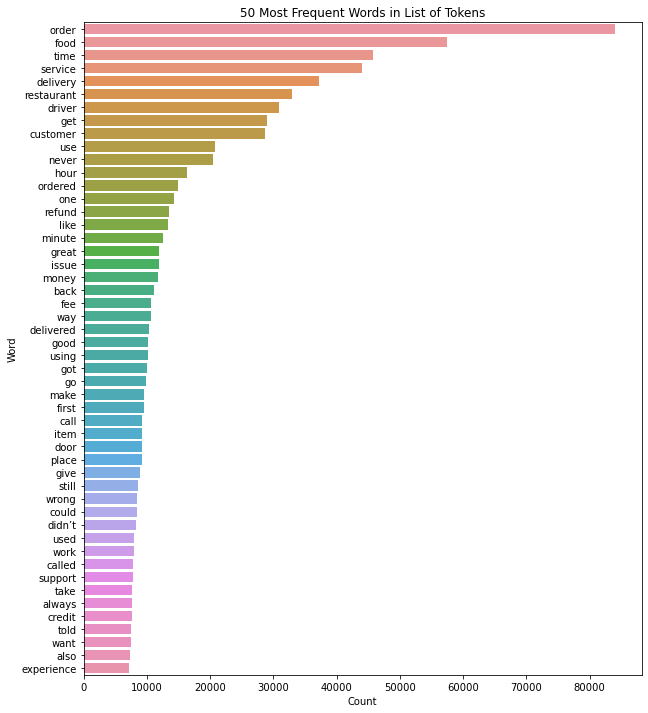

In [48]:
# Display list of tokens after removing extended stopwords
most_freq(stopped_tokens, 50, figsize=(12,25))

Additional removal - remove words that are too indicative of the user's sentiment

The words that we have left are much more insightful, but we also want to remove words that are too indicative of the user's sentiment. By doing so, we will be able to better examine what elements of the apps users considered to be negative or positive without obvious indicator words.


In [49]:
# Add obvious indicator words to stopwords list
stopwords_list.extend(['never', 'refund', 'like', 'great', 'issue', 'postmates', 'fee', 'good', 
                       'first', 'still', 'wrong', 'could', 'didn’t', 'has’t', 'don’t', 'door', 'dash', 'grub', 'hub'])

In [50]:
# Remove stopwords
stopped_tokens = [w.lower() for w in lemmatized_tokens  if w.lower() \
                  not in stopwords_list]

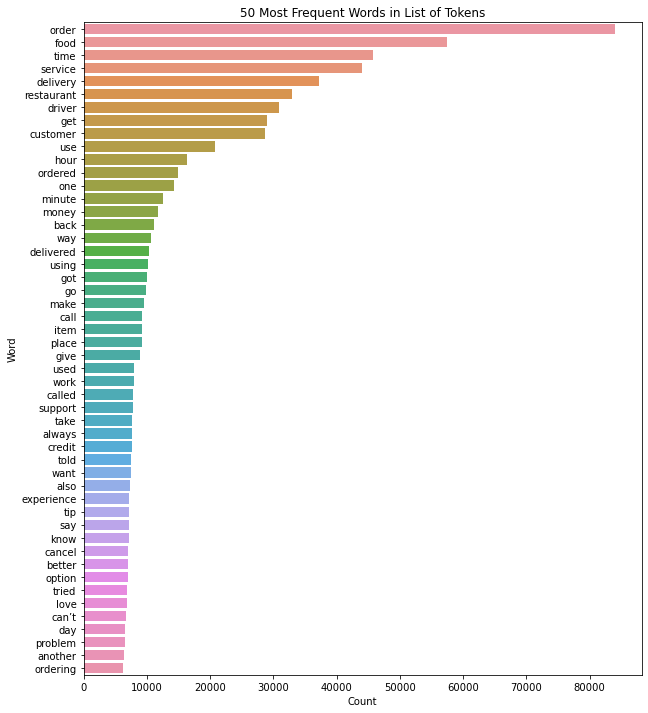

In [51]:
# Display frequency distribution of clean list of tokens
most_freq(stopped_tokens,50, figsize=(12,25))

## Brigram Exploration
Optional

In [52]:
# Get bigrams and frequencies from list of stopped tokens
bigram_measures = nltk.collocations.BigramAssocMeasures()
bigram_finder = nltk.BigramCollocationFinder.from_words(stopped_tokens)
bigram_scores = bigram_finder.score_ngrams(bigram_measures.raw_freq)

In [53]:
# Make a DataFrame from the bigram frequencies
pd.DataFrame(bigram_scores, columns=["Word","Freq"]).head(20)

,Word,Freq
0,"(customer, service)",0.007479
1,"(food, delivery)",0.001608
2,"(delivery, service)",0.001603
3,"(cancel, order)",0.001481
4,"(get, food)",0.001405
5,"(delivery, time)",0.001338
6,"(order, food)",0.001245
7,"(placed, order)",0.001244
8,"(food, delivered)",0.001077
9,"(ordered, food)",0.001077


## Word Cloud Visaulization
all data after removing final list of stopwords

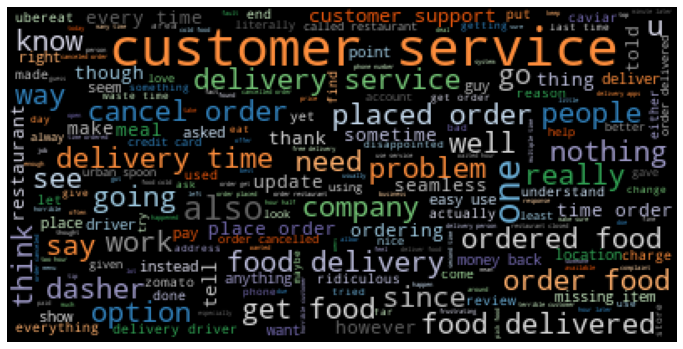

In [54]:
# Create a WordCloud with our stopwords_list and include bigrams
wordcloud = WordCloud(stopwords=stopwords_list,collocations=True, 
                      colormap='tab20c')

# Generate wordcloud from stopped_tokens
wordcloud.generate(','.join(stopped_tokens))

# Plot with matplotlib
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off');

### Importing Mask

In [55]:
# Get image file to use for wordcloud mask
urllib.request.urlretrieve(
  'https://raw.githubusercontent.com/jennifernha/NLP-App-Reviews-Sentiment-Analysis/main/images/bike-delivery.png',
   "bike-delivery.png")

#Create the mask
mask = np.array(Image.open('bike-delivery.png'))

In [56]:
# Write functions to use to create wordclouds
def wordcloud_prep(df_col, stopwords):
    """
    Converts a column of strings into a list of lemmatized tokens with
    a specified list of stopwords removed.

    Args:
        df_col (col) : Sliced column from dataframe with text to be put into
                       a wordcloud
        stopwords (list) : List of stopwords to remove from text.

    Returns:
        stopped_cloud (list) : List of lemmatized tokens with stopwords
                               removed.
    """
    
    # Tokenize and lemmatize corpus into tokens
    cloud_corpus = df_col.to_list()
    cloud_tokens = regexp_tokenize(','.join(cloud_corpus), 
                                   r"([a-zA-Z]+(?:’[a-z]+)?)")
    lemmatized_cloud = lemmatize_tokens(cloud_tokens)

    # Remove specified stopwords
    stopped_cloud = [w.lower() for w in lemmatized_cloud  if w.lower() \
                     not in stopwords]
    return stopped_cloud


def generate_wordcloud(tokens, stopwords=None, collocations=False, 
                       background_color='black', colormap='cool',
                       contour_color='steelblue'):
    """
    Creates and displays a wordcloud using the specified list of tokens,
    stopwords, and mask image.

    Args:
        tokens (list) : List of tokens to generate wordcloud from.
        stopwords (list) : List of stopwords to remove from text.
        collocations (bool) : Whether to include collocations (bigrams) of 
                              two words.
        background_color (color value) : Background color for the wordcloud image.
        colormap (matplotlib colormap) : Matplotlib colormap to randomly draw 
                                         colors from for each word.
        contour_color : Mask contour color.
        mask (nd-array) : Gives a binary mask on where to draw words. If mask 
                          is not None, width and height will be ignored and 
                          the shape of mask will be used instead.

    Returns:
        wordcloud : Image of wordcloud generated using specified text.
    """
    
    # Initalize a WordCloud
    wordcloud = WordCloud(stopwords = stopwords,
                          collocations=collocations, 
                          background_color=background_color, 
                          colormap=colormap,contour_width=2, 
                          contour_color=contour_color,
                          min_font_size=15)

    # Generate wordcloud from tokens
    wordcloud.generate(','.join(tokens))

    plt.figure(figsize = (12, 12), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis('off');
    return wordcloud

### Multi-Class Sentiment WordClouds

In [57]:
# Create and display DataFrames for multi-class sentiments
multi_pos_df = final_df[final_df['multi_sent']==2]
multi_neut_df = final_df[final_df['multi_sent']==1]
multi_neg_df = final_df[final_df['multi_sent']==0]
display(multi_neg_df, multi_neut_df, multi_pos_df)

,date,userName,combined_text,rating,multi_sent,sent_bin_3up,sent_bin_4up
1,5/20/20 18:18,weterpest,"Unreliable, Unhelpful. They have such a great selection of restaurants but service is SO unreliable! I have ordered maybe 5 times through them and the last three have all been really frustrating. The last time I kept calling saying that the driver’s location on the map was not updating and the estimated delivery time kept getting pushed back. The customer service people would just read the estimated delivery time and disconnect the chat without ever reaching out to the driver. Two and a half hours after my food had been picked up and still not delivered, I finally figured out that the driver had car issues and the order was cancelled (3+ hours after being placed). This same type of situation has happened two times other times with the driver having car issues after picking up my order and getting here super late with food that has been sitting out in a car for at least an hour after being picked up, and customer service just doesn’t really do anything to figure it out or get a replacement order sent. I get that car issues happen, but three times in a row with this app isn’t a great track record considering that this has NEVER happened with competitor apps. I was really excited when I found Caviar because of the really great selection of restaurants, but I ended up deleting my account after this last time.",2,0,0,0
2,11/4/20 0:18,Mighty Power,"Deliveries take too long. Well for the last six months understanding pandemic aside because Uber and seamless are doing the same and they are not as late as they are and you are able to reach them, they apologize and always find the best solution or at least give you a credit to make it worthwhile. Caviar support team is easy on saying goodbyes, take a long time and then get back to you with no answer or problem fix, so for the last 10 or so orders all close by restaurants from my house, I waited about an hour to find out the driver was lost and was calling me in Spanish or the driver never showed up, and mostly I had to basically cancel the order and re-order again, I am finding out that the only way to get an order is to first order and then contact Support to make sure they are reaching out to somebody to get your food picked up, I can’t be using an app as such and always waiting around an hour and sometimes get my food cold because it’s been out there so long or never get it and re-order. The worse is customer service that basically tells you it is what it is, goodbye because they have to help somebody else. Knowing seamless GrubHub and Uber eats they always try and they always give you some sort of credit to make up for it immediately before you even asked for it to try to alleviate the problem. Caviar never does until you force their hand. I had just signed up for a subscription plan which I will be canceling since this is just not acceptable",1,0,0,0
3,12/24/18 2:52,anogawa,"Horrendous customer service. I would say the app experience is superior to other delivery apps, which is a shame because the customer service is terrible. Our expected delivery time upon ordering was 8:24 pm, which eventually got pushed back to 8:49 pm. The app notified us of the delay, which is better than other food delivery apps in which I’ve experienced delays but wasn’t notified. However, when order finally arrived, my husband noticed the delivery guy gave us the wrong order. Turns out he had given our order to the wrong person. Driver says he’ll contact support, saying they’ll probably re-deliver. I contact customer support on my own, and the rep offers a refund...okay, but at this point it’s past 9 pm and we still haven’t had dinner. I reply back saying it’s not okay. Rep blames it on me, saying that I selected that the items were missing and I preferred a refund. Except there are no options for “my driver messed up, get me a new order asap”. Eventually he offers $10. Their twitter account offers me $30, s

,date,userName,combined_text,rating,multi_sent,sent_bin_3up,sent_bin_4up
25,1/23/20 22:02,erinbeitel,"Compromised Account Policy. I generally really love everything about Caviar. However, my account was compromised today. Multiple changes made: name change, delivery address added, phone number changed - all things that should be red flags if fraud monitoring is in place. Realistically if my phone number is changed in the app I should probably need to verify that change via email. The order was placed (lobster delivery to NY) and I found out about it via a status update to my email. I immediately contacted them through the app and always asked for several verifying pieces of info. Upon giving them my account was nuked and I was told if I’d like to use caviar I should signup with a new email. (Lol) No way to make sure there weren’t other fraudulent orders, contact support with a ticket associated with the account, get confirmation the account is actually deactivated.. etc. Just K BYE. Um.. let’s revisit this. I appreciate the swift response but that was a pretty over the top reaction to something that pretty obviously seemed to require 1) a hold on my account and 2) a link to reset my password sent to my email.",3,1,1,0
68,5/16/19 18:37,Kittykattorrez,"extremely annoying lack search features. I love caviar. Amazing customer service quick delivery, order tracking, etc. However, I HATE their app layout so much that I am writing the first app review I’ve ever written. There are no advanced search features, no ways to pick a category of food or price point or delivery time or “open now”. I think this app would be highly improved with the addition of advanced search. I’d love to be able to search by distance, food type (Thai/Italian/Mexican etc. But also breakfast/lunch/dessert), open late, dollar signs, delivery fee. The app is so annoying because it lists restaurants and the specifics of each restaurant but all you can do is scroll through these, there is no way to search specifically for what you want. This feature alone makes me want to delete the app entirely and download some other delivery app.",3,1,1,0
133,12/2/20 23:18,Horriblehobbes,"Poor app service since merger/buyout. Definitely noticed a lot of issues with the app after DoorDash took over. It logs me out all the time, tells me I need an update when I already have completed one, etc. Seems buggy or just poorly integrated. Haven’t had issues as of yet with physical services, but I do see other people have and so I’m a little weary. For the amount of fees we pay for delivery I feel like the service should be a bit better and more reliable. Seems like I may as well just order directly from the restaurant when I can. Update two weeks later: your app still blows. I can’t even use it on my phone because it wants me to update and times out every time. Your app blows",3,1,1,0
167,8/28/19 23:30,jimkbobl,"Great app. Company could be better.. So the app works well. Two things about the company are disingenuous and make me think twice about their service. 1. They charge a “Service Fee,” a “Delivery Fee,” and a “Courier Tip,” which tonight added an additional $31 to my order. 2. When they don’t have enough couriers available, they make it look like the restaurant is taking longer. They actually wait to send the order to the restaurant until they have a courier available, but tell the app user that the restaurant is preparing the order. I learned this the hard way trying to get an order from a nearby restaurant. Greater honesty and less cash grab would make this a better service.",3,1,1,0
194,5/24/20 0:09,Teisen77,"volume warnings for hidden delays. I acknowledge that many urbanites are relying on the service in light of COVID-19 but I was disappointed to place a repeat order with a trusted restaurant and then be strung along with delays that extended 90 minutes and ultimately no delivery. I had no way of canceling my order and it would be nice to have been warned that the driver to o

,date,userName,combined_text,rating,multi_sent,sent_bin_3up,sent_bin_4up
0,9/17/20 17:12,Good64774,"Mixed feelings. Caviar used to be a great app. Top quality restaurants, working app, good service. But they recently merged with DoorDash which I have found to be a notoriously worse app. Since the merger, the app seemed to change and your delivery drivers are now from “Dashers”. When you order now and have an issue and try to chat Caviar sometimes their servers are down or you can’t get a hold of them. Your left to call the restaurant who may tell you your food has been ready for a half hour but DoorDash/Caviar hasn’t picked it up and is unreachable right now. Typical DoorDash problems. Although the app needs work and the DoorDash merger is disappointing. When I finally have been able to reach the company and explain various issues. Caviar does issue refunds and credits. This is a positive that some apps like UberEats or Postmates rarely provide. Caviar’s credits/refunds are close to the high level of Seamless/Grubhub. Only reason Seamless/Grubhub are better in this area is refunds and credits can be issued automatically in the app with ease if you run into issues. Caviar, as mentioned above can be difficult to reach and requires more explanation. Ultimately if the Caviar app improves the accessibility of their customer service and they continue to provide credits, I would consider changing my review back to 5 stars. On the other hand, if I keep running into these app issues or if they stop providing credits and refunds for issues I would lower the rating. I’m on the fence.",5,2,1,1
20,10/10/20 16:31,annriseki,"Noticeable enhancements. I hadn’t used Caviar for 6 months because I was in a different state til last week. One of my favorite Dominican restaurants (shoutout to Puerto Viejo!) only offers delivery on Caviar so I had it re-installed. I’m used to the Uber Eats interface but man I love how Caviar always has high quality pics of the food. I also noticed the subtle UI/UX enhancements with the text on the buttons and even the ability to “gift” meals during checkout- really neat! Food delivery “gift giving” is definitely a thing so I thought it was very good how that’s a legit option on the app now. One thing I didn’t like was how longer menu categories have a “toggle to see more” functionality now. I get that it saves screen real estate but I missed it at first and was wondering if the restaurant condensed their menu. Other than that, really happy to be back on this app and thanks for the generous 50% off new user promo :P literally coming back because of Puerto Viejo but the app is so nice that I’ll try to use it more than its competitor, haha. Cheers guys stay safe.",5,2,1,1
21,1/27/20 18:35,leoprd195,"Delete your Caviar app ASAP!!. My account was hacked and within a two-day period, I was charged for over 1k of deliveries all across the country-- sometimes within an hour of each other to different states. I received no alerts that orders were made and only found out when one of the orders was not able to be fulfilled. I've contacted Caviar via email and their website multiple times (since they have no phone number) and have not received a response. It is absolutely WILD to me that they don't have systems in place to catch suspicious orders given how often they are hacked. Moreover, my home and work address were also compromised since they were stored in the app. To refer just people to their banks to dispute the charge is incredibly inappropriate since it was not my credit card that was stolen, it was YOUR PLATFORM that was compromised. Yet, Caviar takes ZERO responsibility. I now have to get a new credit card and update every single one of my autopay services.",5,2,1,1
40,2/25/20 2:53,GoosieMoose,"Horrendous customer service. I keep ordering via caviar thinking they’ll get their operations in order, but every time it’s AT LEAST an hour late. I’m going to stop for real this time! It’s been late in every scenario— when I’ve

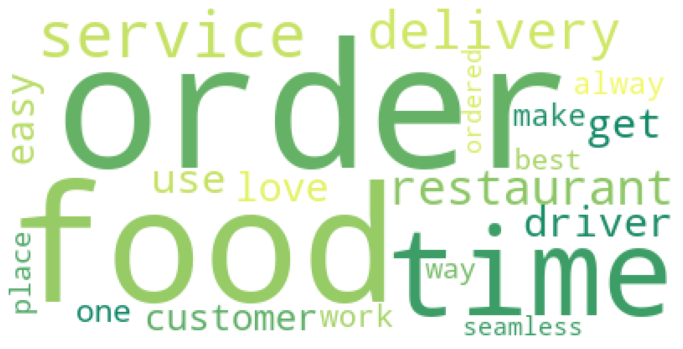

In [58]:
# Generate positive wordcloud for multi-class sentiment
multi_pos_tokens = wordcloud_prep(multi_pos_df['combined_text'], stopwords_list)
multi_pos_wc = generate_wordcloud(multi_pos_tokens, stopwords_list, 
                                  colormap='summer', background_color='white', 
                                  contour_color='green')

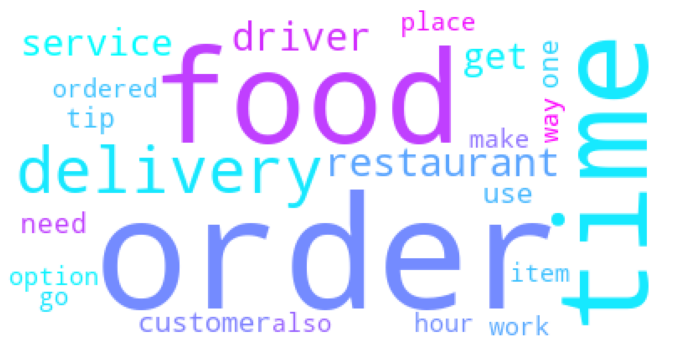

In [59]:
# Generate neutral wordcloud for multi-class sentiment
multi_neut_tokens = wordcloud_prep(multi_neut_df['combined_text'], 
                                   stopwords_list)
multi_neut_wc = generate_wordcloud(multi_neut_tokens, stopwords_list, 
                                   colormap='cool', background_color='white')

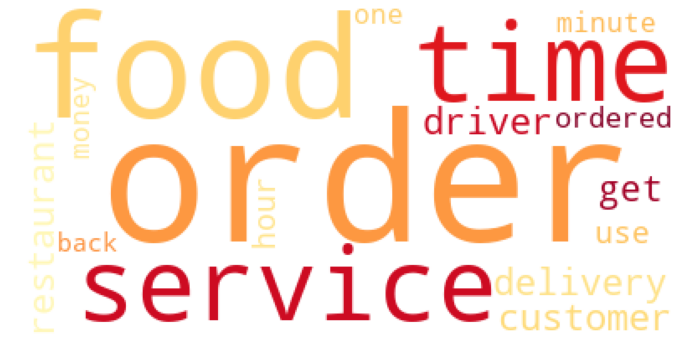

In [60]:
# Generate negative wordcloud for multi-class sentiment
multi_neg_tokens = wordcloud_prep(multi_neg_df['combined_text'], stopwords_list)
multi_neg_wc = generate_wordcloud(multi_neg_tokens, stopwords_list, 
                                  colormap='YlOrRd', background_color='white', 
                                  contour_color='red')

### Binary Classficiation Sentiment (Negative: 1-3, Positive: 4-5)

In [61]:
# Create and display DataFrames for binary sentiments
bin_pos_df = final_df[final_df['sent_bin_4up']==1]
bin_neg_df = final_df[final_df['sent_bin_4up']==0]
display(bin_neg_df, bin_pos_df)

,date,userName,combined_text,rating,multi_sent,sent_bin_3up,sent_bin_4up
1,5/20/20 18:18,weterpest,"Unreliable, Unhelpful. They have such a great selection of restaurants but service is SO unreliable! I have ordered maybe 5 times through them and the last three have all been really frustrating. The last time I kept calling saying that the driver’s location on the map was not updating and the estimated delivery time kept getting pushed back. The customer service people would just read the estimated delivery time and disconnect the chat without ever reaching out to the driver. Two and a half hours after my food had been picked up and still not delivered, I finally figured out that the driver had car issues and the order was cancelled (3+ hours after being placed). This same type of situation has happened two times other times with the driver having car issues after picking up my order and getting here super late with food that has been sitting out in a car for at least an hour after being picked up, and customer service just doesn’t really do anything to figure it out or get a replacement order sent. I get that car issues happen, but three times in a row with this app isn’t a great track record considering that this has NEVER happened with competitor apps. I was really excited when I found Caviar because of the really great selection of restaurants, but I ended up deleting my account after this last time.",2,0,0,0
2,11/4/20 0:18,Mighty Power,"Deliveries take too long. Well for the last six months understanding pandemic aside because Uber and seamless are doing the same and they are not as late as they are and you are able to reach them, they apologize and always find the best solution or at least give you a credit to make it worthwhile. Caviar support team is easy on saying goodbyes, take a long time and then get back to you with no answer or problem fix, so for the last 10 or so orders all close by restaurants from my house, I waited about an hour to find out the driver was lost and was calling me in Spanish or the driver never showed up, and mostly I had to basically cancel the order and re-order again, I am finding out that the only way to get an order is to first order and then contact Support to make sure they are reaching out to somebody to get your food picked up, I can’t be using an app as such and always waiting around an hour and sometimes get my food cold because it’s been out there so long or never get it and re-order. The worse is customer service that basically tells you it is what it is, goodbye because they have to help somebody else. Knowing seamless GrubHub and Uber eats they always try and they always give you some sort of credit to make up for it immediately before you even asked for it to try to alleviate the problem. Caviar never does until you force their hand. I had just signed up for a subscription plan which I will be canceling since this is just not acceptable",1,0,0,0
3,12/24/18 2:52,anogawa,"Horrendous customer service. I would say the app experience is superior to other delivery apps, which is a shame because the customer service is terrible. Our expected delivery time upon ordering was 8:24 pm, which eventually got pushed back to 8:49 pm. The app notified us of the delay, which is better than other food delivery apps in which I’ve experienced delays but wasn’t notified. However, when order finally arrived, my husband noticed the delivery guy gave us the wrong order. Turns out he had given our order to the wrong person. Driver says he’ll contact support, saying they’ll probably re-deliver. I contact customer support on my own, and the rep offers a refund...okay, but at this point it’s past 9 pm and we still haven’t had dinner. I reply back saying it’s not okay. Rep blames it on me, saying that I selected that the items were missing and I preferred a refund. Except there are no options for “my driver messed up, get me a new order asap”. Eventually he offers $10. Their twitter account offers me $30, s

,date,userName,combined_text,rating,multi_sent,sent_bin_3up,sent_bin_4up
0,9/17/20 17:12,Good64774,"Mixed feelings. Caviar used to be a great app. Top quality restaurants, working app, good service. But they recently merged with DoorDash which I have found to be a notoriously worse app. Since the merger, the app seemed to change and your delivery drivers are now from “Dashers”. When you order now and have an issue and try to chat Caviar sometimes their servers are down or you can’t get a hold of them. Your left to call the restaurant who may tell you your food has been ready for a half hour but DoorDash/Caviar hasn’t picked it up and is unreachable right now. Typical DoorDash problems. Although the app needs work and the DoorDash merger is disappointing. When I finally have been able to reach the company and explain various issues. Caviar does issue refunds and credits. This is a positive that some apps like UberEats or Postmates rarely provide. Caviar’s credits/refunds are close to the high level of Seamless/Grubhub. Only reason Seamless/Grubhub are better in this area is refunds and credits can be issued automatically in the app with ease if you run into issues. Caviar, as mentioned above can be difficult to reach and requires more explanation. Ultimately if the Caviar app improves the accessibility of their customer service and they continue to provide credits, I would consider changing my review back to 5 stars. On the other hand, if I keep running into these app issues or if they stop providing credits and refunds for issues I would lower the rating. I’m on the fence.",5,2,1,1
20,10/10/20 16:31,annriseki,"Noticeable enhancements. I hadn’t used Caviar for 6 months because I was in a different state til last week. One of my favorite Dominican restaurants (shoutout to Puerto Viejo!) only offers delivery on Caviar so I had it re-installed. I’m used to the Uber Eats interface but man I love how Caviar always has high quality pics of the food. I also noticed the subtle UI/UX enhancements with the text on the buttons and even the ability to “gift” meals during checkout- really neat! Food delivery “gift giving” is definitely a thing so I thought it was very good how that’s a legit option on the app now. One thing I didn’t like was how longer menu categories have a “toggle to see more” functionality now. I get that it saves screen real estate but I missed it at first and was wondering if the restaurant condensed their menu. Other than that, really happy to be back on this app and thanks for the generous 50% off new user promo :P literally coming back because of Puerto Viejo but the app is so nice that I’ll try to use it more than its competitor, haha. Cheers guys stay safe.",5,2,1,1
21,1/27/20 18:35,leoprd195,"Delete your Caviar app ASAP!!. My account was hacked and within a two-day period, I was charged for over 1k of deliveries all across the country-- sometimes within an hour of each other to different states. I received no alerts that orders were made and only found out when one of the orders was not able to be fulfilled. I've contacted Caviar via email and their website multiple times (since they have no phone number) and have not received a response. It is absolutely WILD to me that they don't have systems in place to catch suspicious orders given how often they are hacked. Moreover, my home and work address were also compromised since they were stored in the app. To refer just people to their banks to dispute the charge is incredibly inappropriate since it was not my credit card that was stolen, it was YOUR PLATFORM that was compromised. Yet, Caviar takes ZERO responsibility. I now have to get a new credit card and update every single one of my autopay services.",5,2,1,1
40,2/25/20 2:53,GoosieMoose,"Horrendous customer service. I keep ordering via caviar thinking they’ll get their operations in order, but every time it’s AT LEAST an hour late. I’m going to stop for real this time! It’s been late in every scenario— when I’ve

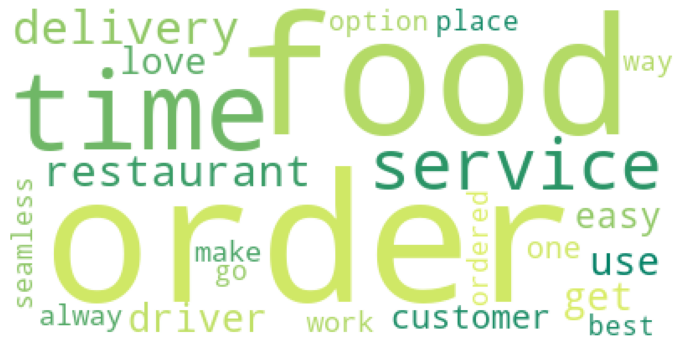

In [62]:
# Generate positive wordcloud for binary sentiment
bin_pos_tokens = wordcloud_prep(bin_pos_df['combined_text'], stopwords_list)
bin_pos_wc = generate_wordcloud(bin_pos_tokens, stopwords_list, 
                                colormap='summer', background_color='white', 
                                contour_color='green')

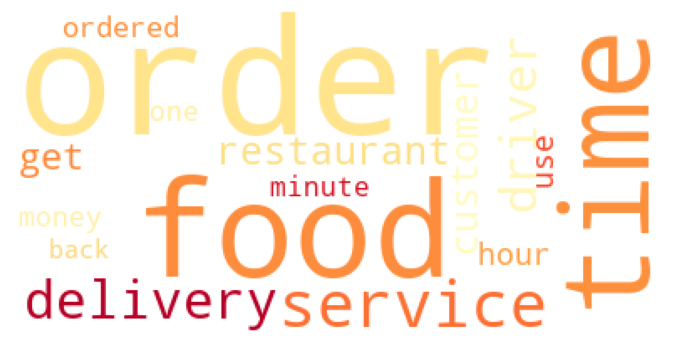

In [63]:
# Generate negative wordcloud for binary sentiment
bin_neg_tokens = wordcloud_prep(bin_neg_df['combined_text'], stopwords_list)
bin_neg_wc = generate_wordcloud(bin_neg_tokens, stopwords_list, 
                                colormap='YlOrRd', background_color='white', 
                                contour_color='red')

## Multi-Class: Negative (1-2), Neutral (3), Positive (4-5)

### Pre-processing: Train-Test Split

In [64]:
# Make X and y
y_multi = final_df['multi_sent'].copy()
X = final_df['combined_text'].copy()

# Train Test Split
X_multi_train, X_multi_test, y_multi_train, y_multi_test = train_test_split(X, y_multi, 
                                                                            test_size=0.3, 
                                                                            random_state=27)

# Check y_train value counts
y_multi_train.value_counts(normalize=True)

0    0.542659
2    0.396385
1    0.060956
Name: multi_sent, dtype: float64

In [65]:
# Initialize RegExp tokenizer
tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")

# Make a TF-IDF vectorizer
vectorizer_multi = TfidfVectorizer(tokenizer=tokenizer.tokenize,
                                   token_pattern=r"([a-zA-Z]+(?:’[a-z]+)?)",
                                   stop_words=stopwords_list,
                                   ngram_range=(1,2))

# Vectorize data and make X_train_tfidf and X_test_tfidf
X_multi_train_tfidf = vectorizer_multi.fit_transform(X_multi_train)
X_multi_test_tfidf = vectorizer_multi.transform(X_multi_test)
X_multi_train_tfidf

<46919x676844 sparse matrix of type '<class 'numpy.float64'>'
	with 3150202 stored elements in Compressed Sparse Row format>

### Model 1: Logistic Regression

In [66]:
# Fit Logistic Regression model on multi-class training data
logreg = LogisticRegression(max_iter=200, class_weight='balanced')
logreg.fit(X_multi_train_tfidf, y_multi_train)

LogisticRegression(class_weight='balanced', max_iter=200)

In [67]:
# Model evaluation function
def evaluate_model(y_test, y_train, X_test, X_train, clf, n_class=3, 
                   figsize=(10,5), digits=2, params=False):
    """
    Displays evaluation metrics including classification report, confusion
    matrix, ROC-AUC curve.
    
    If the argument 'params' is passed, will display a table of the 
    parameters hyperparameters used in the model.

    Args:
        y_test (Series) : Testing data with target variable.
        y_train (Series) : Training data with target variable.
        X_test (DataFrame) : Testing data with vectorized feature variables.
        X_train (DataFrame) : Training data with vectorized feature variables.
        clf (classifier object) : Type of classificatier model to use.
        n_class (int) : Number of classes for classification task.
        figsize (int, int) : Figure dimensions. Default is (10,5)
        digits (int) : Number of decimal places to display in classification
                       report
        params (bool) : Prints table of hyperparameters used in model.
        
    Returns:
    
    """

    sns.set_style('dark')

    # Get Predictions
    y_hat_test = clf.predict(X_test)
    
    # Display training and test accuracy
    print("****TRAIN VS TEST ACCURACY****")
    print("\n", f"Training Score: {round(clf.score(X_train, y_train),2)}", 
          "\n", f"Test Score: {round(clf.score(X_test, y_test),2)}", "\n")
    
    # Display classification report
    print("****CLASSIFICATION REPORT - TEST DATA****")
    print(metrics.classification_report(y_test, y_hat_test, digits=digits))
    print("****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****")
    
    if n_class == 3:
        # Create a figure/axes for confusion matrix and ROC curve
        fig, ax = plt.subplots(ncols=2, figsize=figsize)

        # Plot confusion matrix
        plot_confusion_matrix(estimator=clf, X=X_test, y_true=y_test, 
                              cmap='Purples', normalize='true', ax=ax[0], 
                              display_labels=['Negative', 'Neutral', 
                                              'Positive'])
        ax[0].set_title('Confusion Matrix')
        
        # Plot ROC-AUC curve
        pred_prob = clf.predict_proba(X_test)
        fpr={}
        tpr={}
        thresh={}

        for i in range(n_class):    
            fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], 
                                                  pos_label=i)
            
        ax = ax[1]
        ax.grid()
        ax.plot(fpr[0], tpr[0], linestyle='-',color='red', label='Negative')
        ax.plot(fpr[1], tpr[1], linestyle='-',color='blue', label='Neutral')
        ax.plot(fpr[2], tpr[2], linestyle='-',color='green', label='Positive')
        ax.set_title('ROC-AUC curve')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive rate')
        ax.legend(loc='best')
        ax.plot([0,1], [0,1], ls='-', color='purple')

        plt.tight_layout()
        plt.show()

    elif n_class == 2:
        fig, axes = plt.subplots(ncols=2, 
                                 figsize=figsize)

        # Plot confusion matrix
        metrics.plot_confusion_matrix(clf, X_test,
                                      y_test,normalize='true',
                                      cmap='Purples',ax=axes[0],
                                      display_labels=['Negative', 'Positive'])
        axes[0].set_title('Confusion Matrix')

        # Plot ROC-AUC curve
        metrics.plot_roc_curve(clf,X_test,y_test,ax=axes[1])

        ax = axes[1]
        ax.plot([0,1],[0,1], ls='-', color='purple')
        ax.grid()
        ax.set_title('ROC-AUC Curve')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive rate')
        ax.get_legend().remove()

        plt.tight_layout()
        plt.show()
        
    # Print model parameters
    if params == True:
        print("****MODEL PARAMETERS****")
        params = pd.DataFrame(pd.Series(clf.get_params()))
        params.columns=['parameters']
        display(params)

****TRAIN VS TEST ACCURACY****

 Training Score: 0.91 
 Test Score: 0.79 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.82      0.88      0.85     10916
           1       0.25      0.37      0.29      1215
           2       0.87      0.72      0.79      7978

    accuracy                           0.79     20109
   macro avg       0.65      0.66      0.64     20109
weighted avg       0.81      0.79      0.79     20109

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


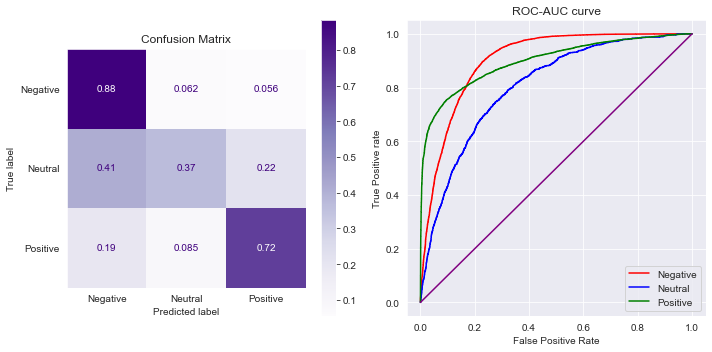

In [68]:
# Evaluate model performance
evaluate_model(y_multi_test, y_multi_train, 
               X_multi_test_tfidf, X_multi_train_tfidf, logreg)

### Model 2: Random Forest

In [69]:
# Fit Random Forest model on multi-class training data
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_multi_train_tfidf, y_multi_train)

RandomForestClassifier(class_weight='balanced')

****TRAIN VS TEST ACCURACY****

 Training Score: 1.0 
 Test Score: 0.8 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.78      0.92      0.85     10916
           1       0.40      0.00      0.00      1215
           2       0.82      0.74      0.78      7978

    accuracy                           0.80     20109
   macro avg       0.67      0.56      0.54     20109
weighted avg       0.77      0.80      0.77     20109

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


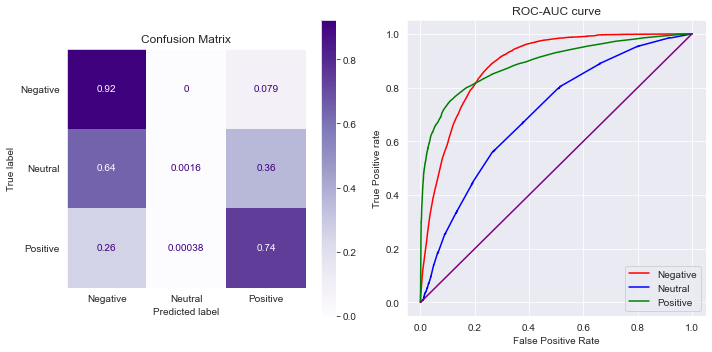

In [70]:
# Evaluate model performance
evaluate_model(y_multi_test, y_multi_train, X_multi_test_tfidf, 
               X_multi_train_tfidf, rf)

### Model 3: Support Vector Classification (SVC)

In [71]:
# Fit SVC model on binary training data
svc = LinearSVC(class_weight='balanced')
svc.fit(X_multi_train_tfidf, y_multi_train)

LinearSVC(class_weight='balanced')

****TRAIN VS TEST ACCURACY****

 Training Score: 1.0 
 Test Score: 0.81 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.80      0.93      0.86     10916
           1       0.28      0.09      0.14      1215
           2       0.86      0.75      0.80      7978

    accuracy                           0.81     20109
   macro avg       0.65      0.59      0.60     20109
weighted avg       0.79      0.81      0.79     20109

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

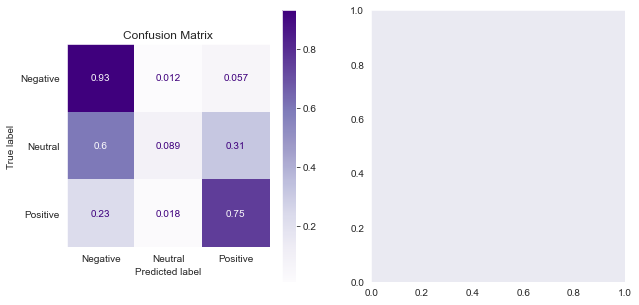

In [72]:
# Evaluate model performance
evaluate_model(y_multi_test, y_multi_train, X_multi_test_tfidf, 
               X_multi_train_tfidf, svc)

## Binary: Negative (1-3), Positive (4-5)

### Pre-processing: Train-Test Split

In [73]:
# Make y
y_bin = final_df['sent_bin_4up'].copy()

## Train Test Split
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X, y_bin, 
                                                                    test_size=0.3, 
                                                                    random_state=27)

# Check y_train value counts
y_bin_train.value_counts(normalize=True)

0    0.603615
1    0.396385
Name: sent_bin_4up, dtype: float64

In [74]:
# Make a TF-IDF vectorizer using previously created tokenizer
vectorizer_bin = TfidfVectorizer(tokenizer=tokenizer.tokenize,
                                 token_pattern=r"([a-zA-Z]+(?:’[a-z]+)?)",
                                 stop_words=stopwords_list,
                                 ngram_range=(1,2))

# Vectorize data and make X_train_tfidf and X_test_tfidf
X_bin_train_tfidf = vectorizer_bin.fit_transform(X_bin_train)
X_bin_test_tfidf = vectorizer_bin.transform(X_bin_test)
X_bin_train_tfidf

<46919x676844 sparse matrix of type '<class 'numpy.float64'>'
	with 3150202 stored elements in Compressed Sparse Row format>

### Model 1: Logistic Regression

In [75]:
# Fit Logistic Regression model on binary training data
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_bin_train_tfidf, y_bin_train)

LogisticRegression(class_weight='balanced')

****TRAIN VS TEST ACCURACY****

 Training Score: 0.9 
 Test Score: 0.85 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.85      0.91      0.88     12131
           1       0.85      0.75      0.80      7978

    accuracy                           0.85     20109
   macro avg       0.85      0.83      0.84     20109
weighted avg       0.85      0.85      0.85     20109

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


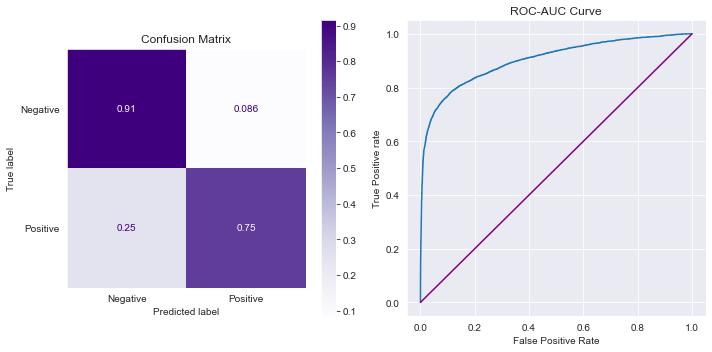

In [76]:
# Evaluate model performance
evaluate_model(y_bin_test, y_bin_train, 
               X_bin_test_tfidf, X_bin_train_tfidf, logreg, 2)

### Model 2: Random Forest

In [77]:
# Fit Random Forest model on binary training data
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_bin_train_tfidf, y_bin_train)

RandomForestClassifier(class_weight='balanced')

****TRAIN VS TEST ACCURACY****

 Training Score: 1.0 
 Test Score: 0.84 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.82      0.93      0.87     12131
           1       0.86      0.70      0.77      7978

    accuracy                           0.84     20109
   macro avg       0.84      0.81      0.82     20109
weighted avg       0.84      0.84      0.83     20109

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


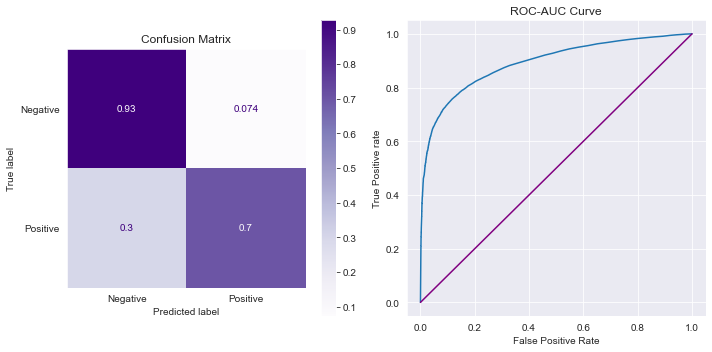

In [78]:
# Evaluate model performance
evaluate_model(y_bin_test, y_bin_train, 
               X_bin_test_tfidf, X_bin_train_tfidf, rf, 2)

### Model 3: Support Vector Classification (SVC)

In [79]:
# Fit SVC model on binary training data
svc = LinearSVC()
svc.fit(X_bin_train_tfidf, y_bin_train)

LinearSVC()

****TRAIN VS TEST ACCURACY****

 Training Score: 1.0 
 Test Score: 0.85 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.84      0.94      0.89     12131
           1       0.89      0.72      0.80      7978

    accuracy                           0.85     20109
   macro avg       0.86      0.83      0.84     20109
weighted avg       0.86      0.85      0.85     20109

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


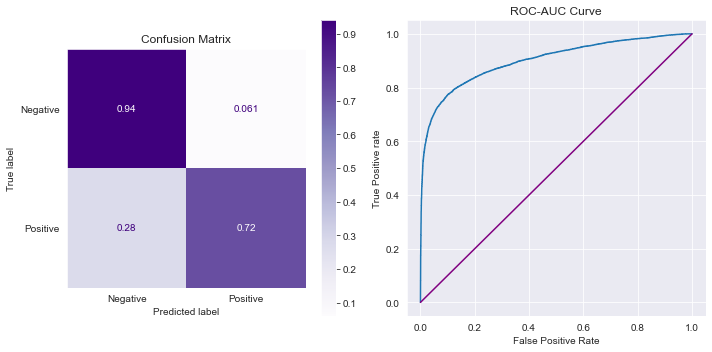

In [80]:
# Evaluate model performance
evaluate_model(y_bin_test, y_bin_train, 
               X_bin_test_tfidf, X_bin_train_tfidf, svc, 2)

## Binary: Negative (1-2), Positive (3-5)

### Pre-processing: Train-Test Split

In [81]:
# Make y
y_bin = final_df['sent_bin_3up'].copy()

## Train Test Split
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X, y_bin, 
                                                                    test_size=0.3, 
                                                                    random_state=27)

# Check y_train value counts
y_bin_train.value_counts(normalize=True)

0    0.542659
1    0.457341
Name: sent_bin_3up, dtype: float64

In [82]:
# Make a TF-IDF vectorizer using previously created tokenizer
vectorizer_bin = TfidfVectorizer(tokenizer=tokenizer.tokenize,
                                 token_pattern=r"([a-zA-Z]+(?:’[a-z]+)?)",
                                 stop_words=stopwords_list,
                                 ngram_range=(1,2))

# Vectorize data and make X_train_tfidf and X_test_tfidf
X_bin_train_tfidf = vectorizer_bin.fit_transform(X_bin_train)
X_bin_test_tfidf = vectorizer_bin.transform(X_bin_test)
X_bin_train_tfidf

<46919x676844 sparse matrix of type '<class 'numpy.float64'>'
	with 3150202 stored elements in Compressed Sparse Row format>

### Model 1: Logistic Regression

In [83]:
# Fit Logistic Regression model on binary training data
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_bin_train_tfidf, y_bin_train)

LogisticRegression(class_weight='balanced')

****TRAIN VS TEST ACCURACY****

 Training Score: 0.9 
 Test Score: 0.84 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.82      0.91      0.86     10916
           1       0.87      0.76      0.81      9193

    accuracy                           0.84     20109
   macro avg       0.84      0.83      0.83     20109
weighted avg       0.84      0.84      0.84     20109

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


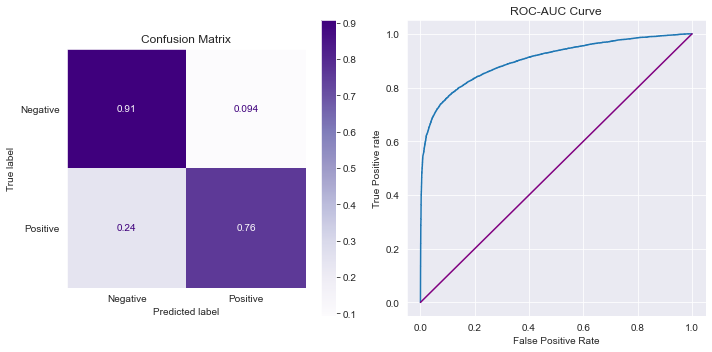

In [84]:
# Evaluate model performance
evaluate_model(y_bin_test, y_bin_train, 
               X_bin_test_tfidf, X_bin_train_tfidf, logreg, 2)

### Model 2: Random Forest

In [85]:
# Fit Random Forest model on binary training data
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_bin_train_tfidf, y_bin_train)

RandomForestClassifier(class_weight='balanced')

****TRAIN VS TEST ACCURACY****

 Training Score: 1.0 
 Test Score: 0.82 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.80      0.90      0.84     10916
           1       0.86      0.73      0.79      9193

    accuracy                           0.82     20109
   macro avg       0.83      0.81      0.82     20109
weighted avg       0.82      0.82      0.82     20109

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


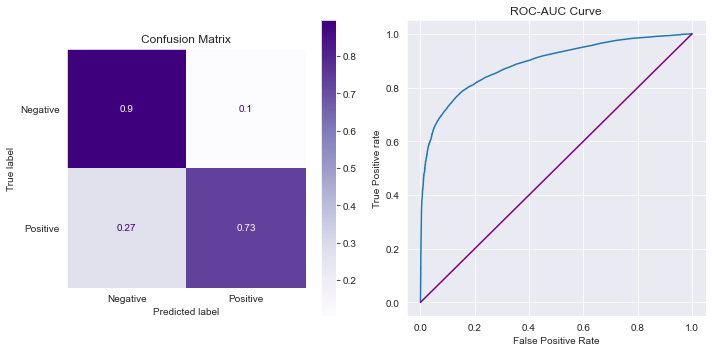

In [86]:
# Evaluate model performance
evaluate_model(y_bin_test, y_bin_train, 
               X_bin_test_tfidf, X_bin_train_tfidf, rf, 2)

### Model 3: Support Vector Classification (SVC)

In [87]:
# Fit SVC model on binary training data
svc = LinearSVC()
svc.fit(X_bin_train_tfidf, y_bin_train)

LinearSVC()

****TRAIN VS TEST ACCURACY****

 Training Score: 1.0 
 Test Score: 0.84 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.81      0.92      0.86     10916
           1       0.88      0.74      0.81      9193

    accuracy                           0.84     20109
   macro avg       0.85      0.83      0.83     20109
weighted avg       0.84      0.84      0.84     20109

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


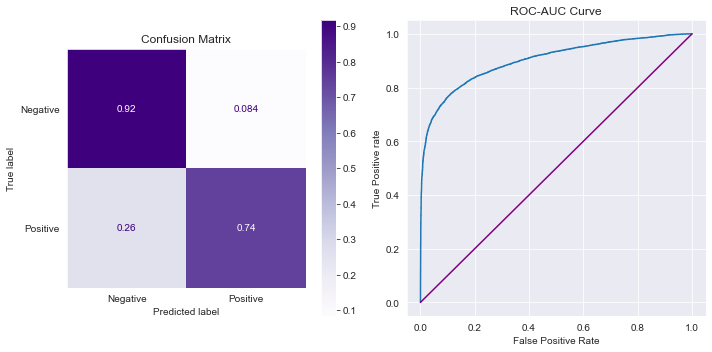

In [88]:
# Evaluate model performance
evaluate_model(y_bin_test, y_bin_train, 
               X_bin_test_tfidf, X_bin_train_tfidf, svc, 2)